In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import PIL

import numpy as np
import matplotlib.pyplot as plt

import os
import re
import copy

from tqdm.auto import tqdm

In [2]:
from efficientnet_pytorch import EfficientNet

In [3]:
import matplotlib.image as mpimg

In [4]:
f_path = "data/flowers/trimaps/"

In [5]:
IMAGE_SIZE = 224

In [6]:
USE_CUDA = True

In [7]:
1360 / 80

17.0

In [8]:
class FlowerImages(Dataset):
    def __init__(self, folder_path,  transforms=None):
        self.data_root_folder = folder_path
        self.image_list  = self.load_image_list(self.data_root_folder)
        self.label_list = []
        self.transforms = transforms
        
        self.class_num_list = {}
        self.class2num = {}
        self.calulate_image_class()
        
    def calulate_image_class(self):
        for image_file in self.image_list:
            image_num = int(re.split(r"(_|\.)",image_file)[-3]) - 1
            self.label_list.append(image_num // 80)
            # print(image_file, image_num // 80)
            if not image_num // 80 in self.class_num_list:
                self.class_num_list[image_num // 80] = 0
            else:
                self.class_num_list[image_num // 80] += 1
        
        for i, key in enumerate(sorted(self.class_num_list)):
            self.class2num[key] = i
            
        
        return
        
        
    def load_image_list(self, folder_path):
        image_list = []
        for image_file in os.listdir(folder_path):
            if image_file.endswith(".png"):
                image_list.append(os.path.join(folder_path, image_file))
        
        return image_list
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        # Open image
        img2 = mpimg.imread(single_image_path)
        channel1 = img2[:,:,0]
        channel1[np.where(channel1 > 0)] = 1
        channel1[np.where(channel1 < 1)] = 0
        channel2 = img2[:,:,1]
        channel2[np.where(channel2 > 0)] = 1
        channel2[np.where(channel2 < 1)] = 0
        channel1[np.where(channel2 > 0)] = 0
           
        img_tensor = channel1
        if self.transforms is not None:
            img_tensor = self.transforms(img_tensor)
            img_tensor = transforms.ToTensor()(np.array(img_tensor))
            
        label = self.class2num[self.label_list[index]]
        return img_tensor, label
        

In [9]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(mode="F"),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
fi = FlowerImages(f_path, transforms=my_transforms)

In [11]:
fi[200][1]

4

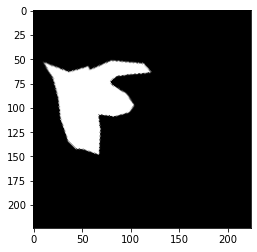

In [12]:
plt.imshow(fi[200][0][0],cmap="gray")

In [13]:
train_dataset_len = int(0.8 * len(fi))
test_dataset_len = len(fi) - train_dataset_len

In [14]:
train_dataset, test_dataset = torch.utils.data.random_split(fi,[train_dataset_len, test_dataset_len])

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0)

In [16]:
model = EfficientNet.from_name('efficientnet-b0', in_channels = 1, num_classes = len(fi.class2num))

In [17]:
pretrained_dict = torch.load("11_4_eff_pre_train.pth")

In [18]:
model_dict = model.state_dict()

In [19]:
for k in model_dict:
    print(k)

_conv_stem.weight
_bn0.weight
_bn0.bias
_bn0.running_mean
_bn0.running_var
_bn0.num_batches_tracked
_blocks.0._depthwise_conv.weight
_blocks.0._bn1.weight
_blocks.0._bn1.bias
_blocks.0._bn1.running_mean
_blocks.0._bn1.running_var
_blocks.0._bn1.num_batches_tracked
_blocks.0._se_reduce.weight
_blocks.0._se_reduce.bias
_blocks.0._se_expand.weight
_blocks.0._se_expand.bias
_blocks.0._project_conv.weight
_blocks.0._bn2.weight
_blocks.0._bn2.bias
_blocks.0._bn2.running_mean
_blocks.0._bn2.running_var
_blocks.0._bn2.num_batches_tracked
_blocks.1._expand_conv.weight
_blocks.1._bn0.weight
_blocks.1._bn0.bias
_blocks.1._bn0.running_mean
_blocks.1._bn0.running_var
_blocks.1._bn0.num_batches_tracked
_blocks.1._depthwise_conv.weight
_blocks.1._bn1.weight
_blocks.1._bn1.bias
_blocks.1._bn1.running_mean
_blocks.1._bn1.running_var
_blocks.1._bn1.num_batches_tracked
_blocks.1._se_reduce.weight
_blocks.1._se_reduce.bias
_blocks.1._se_expand.weight
_blocks.1._se_expand.bias
_blocks.1._project_conv.weigh

In [20]:
model_dict['_fc.weight'].shape

torch.Size([16, 1280])

In [21]:
for k in pretrained_dict:
    print(k)

efficient._conv_stem.weight
efficient._bn0.weight
efficient._bn0.bias
efficient._bn0.running_mean
efficient._bn0.running_var
efficient._bn0.num_batches_tracked
efficient._blocks.0._depthwise_conv.weight
efficient._blocks.0._bn1.weight
efficient._blocks.0._bn1.bias
efficient._blocks.0._bn1.running_mean
efficient._blocks.0._bn1.running_var
efficient._blocks.0._bn1.num_batches_tracked
efficient._blocks.0._se_reduce.weight
efficient._blocks.0._se_reduce.bias
efficient._blocks.0._se_expand.weight
efficient._blocks.0._se_expand.bias
efficient._blocks.0._project_conv.weight
efficient._blocks.0._bn2.weight
efficient._blocks.0._bn2.bias
efficient._blocks.0._bn2.running_mean
efficient._blocks.0._bn2.running_var
efficient._blocks.0._bn2.num_batches_tracked
efficient._blocks.1._expand_conv.weight
efficient._blocks.1._bn0.weight
efficient._blocks.1._bn0.bias
efficient._blocks.1._bn0.running_mean
efficient._blocks.1._bn0.running_var
efficient._blocks.1._bn0.num_batches_tracked
efficient._blocks.1._d

In [22]:
intersect_dict = {}
for k in model_dict:
    cor_name = "efficient." + k
    if k == "_fc.weight" or k == "_fc.bias":
        continue
    if cor_name in pretrained_dict:
        intersect_dict[k] = pretrained_dict[cor_name]

In [23]:
for k in intersect_dict:
    print(k)

_conv_stem.weight
_bn0.weight
_bn0.bias
_bn0.running_mean
_bn0.running_var
_bn0.num_batches_tracked
_blocks.0._depthwise_conv.weight
_blocks.0._bn1.weight
_blocks.0._bn1.bias
_blocks.0._bn1.running_mean
_blocks.0._bn1.running_var
_blocks.0._bn1.num_batches_tracked
_blocks.0._se_reduce.weight
_blocks.0._se_reduce.bias
_blocks.0._se_expand.weight
_blocks.0._se_expand.bias
_blocks.0._project_conv.weight
_blocks.0._bn2.weight
_blocks.0._bn2.bias
_blocks.0._bn2.running_mean
_blocks.0._bn2.running_var
_blocks.0._bn2.num_batches_tracked
_blocks.1._expand_conv.weight
_blocks.1._bn0.weight
_blocks.1._bn0.bias
_blocks.1._bn0.running_mean
_blocks.1._bn0.running_var
_blocks.1._bn0.num_batches_tracked
_blocks.1._depthwise_conv.weight
_blocks.1._bn1.weight
_blocks.1._bn1.bias
_blocks.1._bn1.running_mean
_blocks.1._bn1.running_var
_blocks.1._bn1.num_batches_tracked
_blocks.1._se_reduce.weight
_blocks.1._se_reduce.bias
_blocks.1._se_expand.weight
_blocks.1._se_expand.bias
_blocks.1._project_conv.weigh

In [24]:
# 2. overwrite entries in the existing state dict
model_dict.update(intersect_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

<All keys matched successfully>

In [25]:
# del intersect_dict
del pretrained_dict

In [26]:
if torch.cuda.is_available() and USE_CUDA:
    model = model.cuda()

In [27]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
epoches = 100

In [ ]:
for epoch in range(epoches):
    loss_epoch = []
    model.train()
    for batch_inputs, batch_scores in tqdm(train_dataloader):
        #print(batch_inputs.shape)
        #print(batch_scores.shape)
        if torch.cuda.is_available() and USE_CUDA:
                batch_inputs = batch_inputs.to("cuda")
                batch_scores = batch_scores.to("cuda")

        batch_pred = model(batch_inputs)

        loss = loss_fun(batch_pred, batch_scores)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss.item())

        # break

    model.eval()
    acc_epoch = []
    for batch_inputs, batch_scores in tqdm(test_dataloader):
        if torch.cuda.is_available() and USE_CUDA:
                batch_inputs = batch_inputs.to("cuda")
                batch_scores = batch_scores.to("cuda")

        batch_pred = model(batch_inputs)

        _, predictions = torch.max(batch_pred, dim=-1)

        acc = torch.mean(predictions.eq(batch_scores).float())

        acc_epoch.append(acc.item())

        # break

    avg_loss = np.mean(loss_epoch)
    avg_acc = np.mean(acc_epoch)
    print("epoch: {}, avg train loss {:.4f}, avg test acc {:.4f}".format(epoch, avg_loss, avg_acc))


epoch: 0, avg train loss 2.7383, avg test acc 0.1364



epoch: 1, avg train loss 2.5726, avg test acc 0.0739



epoch: 2, avg train loss 2.5725, avg test acc 0.1761



epoch: 3, avg train loss 2.4847, avg test acc 0.1989



epoch: 4, avg train loss 2.3921, avg test acc 0.1307



epoch: 5, avg train loss 2.3446, avg test acc 0.0852



epoch: 6, avg train loss 2.2844, avg test acc 0.1420



epoch: 7, avg train loss 2.2585, avg test acc 0.1818



epoch: 8, avg train loss 2.2801, avg test acc 0.2330



epoch: 9, avg train loss 2.2218, avg test acc 0.2784



epoch: 10, avg train loss 2.1661, avg test acc 0.2955



epoch: 11, avg train loss 2.1544, avg test acc 0.1989



epoch: 12, avg train loss 2.0782, avg test acc 0.2443



epoch: 13, avg train loss 2.1114, avg test acc 0.3068



epoch: 14, avg train loss 2.1183, avg test acc 0.2898



epoch: 15, avg train loss 2.0590, avg test acc 0.2727



epoch: 16, avg train loss 2.0386, avg test acc 0.3636



epoch: 17, avg train loss 2.0667, avg test acc 0.3011



epoch: 18, avg train loss 1.9243, avg test acc 0.3068



epoch: 19, avg train loss 1.9453, avg test acc 0.3352



epoch: 20, avg train loss 1.9942, avg test acc 0.3011



epoch: 21, avg train loss 1.9116, avg test acc 0.3239



epoch: 22, avg train loss 1.8878, avg test acc 0.3693



epoch: 23, avg train loss 1.8744, avg test acc 0.4148



epoch: 24, avg train loss 1.8642, avg test acc 0.3523



epoch: 25, avg train loss 1.8153, avg test acc 0.4205



epoch: 26, avg train loss 1.7731, avg test acc 0.3466



epoch: 27, avg train loss 1.7635, avg test acc 0.3693



epoch: 28, avg train loss 1.7611, avg test acc 0.4375



epoch: 29, avg train loss 1.7207, avg test acc 0.3693



epoch: 30, avg train loss 1.7538, avg test acc 0.3807



epoch: 31, avg train loss 1.7531, avg test acc 0.4261



epoch: 32, avg train loss 1.6886, avg test acc 0.2670



epoch: 33, avg train loss 1.7339, avg test acc 0.5000



epoch: 34, avg train loss 1.6033, avg test acc 0.3636



epoch: 35, avg train loss 1.6419, avg test acc 0.4205



epoch: 36, avg train loss 1.6321, avg test acc 0.4205



epoch: 37, avg train loss 1.5983, avg test acc 0.4432



epoch: 38, avg train loss 1.6389, avg test acc 0.4602



epoch: 39, avg train loss 1.5880, avg test acc 0.4773



epoch: 40, avg train loss 1.6079, avg test acc 0.4659



epoch: 41, avg train loss 1.5545, avg test acc 0.4830



epoch: 42, avg train loss 1.5937, avg test acc 0.4489



epoch: 43, avg train loss 1.5018, avg test acc 0.4716



epoch: 44, avg train loss 1.5428, avg test acc 0.5625



epoch: 45, avg train loss 1.4442, avg test acc 0.3864



epoch: 46, avg train loss 1.5234, avg test acc 0.5398



epoch: 47, avg train loss 1.4531, avg test acc 0.5170



epoch: 48, avg train loss 1.5385, avg test acc 0.4602



epoch: 49, avg train loss 1.4768, avg test acc 0.4545



epoch: 50, avg train loss 1.4475, avg test acc 0.3636



epoch: 51, avg train loss 1.4402, avg test acc 0.5000



epoch: 52, avg train loss 1.4263, avg test acc 0.5284



epoch: 53, avg train loss 1.4044, avg test acc 0.5341



epoch: 54, avg train loss 1.3815, avg test acc 0.4318



epoch: 55, avg train loss 1.4497, avg test acc 0.5739



epoch: 56, avg train loss 1.4058, avg test acc 0.5795



epoch: 57, avg train loss 1.3797, avg test acc 0.5455



epoch: 58, avg train loss 1.3714, avg test acc 0.5000



epoch: 59, avg train loss 1.3241, avg test acc 0.5398



epoch: 60, avg train loss 1.3981, avg test acc 0.4830



epoch: 61, avg train loss 1.3235, avg test acc 0.5170



epoch: 62, avg train loss 1.3648, avg test acc 0.4489



epoch: 63, avg train loss 1.3561, avg test acc 0.4261



epoch: 64, avg train loss 1.3049, avg test acc 0.5795



epoch: 65, avg train loss 1.3127, avg test acc 0.5909



epoch: 66, avg train loss 1.2670, avg test acc 0.6080



epoch: 67, avg train loss 1.2992, avg test acc 0.5739



epoch: 68, avg train loss 1.3202, avg test acc 0.5227



epoch: 69, avg train loss 1.2927, avg test acc 0.5625



epoch: 70, avg train loss 1.2432, avg test acc 0.5739



epoch: 71, avg train loss 1.2523, avg test acc 0.5909



epoch: 72, avg train loss 1.2052, avg test acc 0.6023



epoch: 73, avg train loss 1.2418, avg test acc 0.5625



epoch: 74, avg train loss 1.2416, avg test acc 0.5852



epoch: 75, avg train loss 1.1781, avg test acc 0.5511


In [ ]:
# model

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
# torch.save(model.state_dict(), "11_4_eff_flowers_night_pre_trained_100_16.pth")